In [ ]:
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
from icecream import ic

try:
    wildfire_df = pd.read_csv('../Dataset/alexnet.csv')
    ic('Datasets \'alexnet.csv\' loaded successfully')
except Exception as e:
    ic(f'Error loading dataset: {e}')

In [49]:
print(f'Shape : {wildfire_df.shape}')

print(wildfire_df.info())

Shape : (1800, 2050)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Columns: 2050 entries, feature_1 to label_encoded
dtypes: float64(2048), int64(1), object(1)
memory usage: 28.2+ MB
None


In [4]:
print(f"Show 'label' column unique values: {wildfire_df['label'].unique()}")

Show 'label' column unique values: ['fire' 'non fire' 'Smoke']


In [5]:
wildfire_df['label'] = wildfire_df['label'].apply(lambda x: x.lower())
print(wildfire_df['label'].unique())

['fire' 'non fire' 'smoke']


In [6]:
wildfire_df['label_encoded'] = wildfire_df['label'].map({
    'non fire': 0,
    'fire': 1,
    'smoke': 2
})

In [7]:
X = wildfire_df.iloc[:,:-2].values
y = wildfire_df['label_encoded'].values

In [8]:
print(wildfire_df['label_encoded'].unique)

<bound method Series.unique of 0       1
1       1
2       1
3       1
4       1
       ..
1795    2
1796    2
1797    2
1798    2
1799    2
Name: label_encoded, Length: 1800, dtype: int64>


### Support Vector Machine (SVM)

In [9]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid= param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001, 0.1, 1]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10, 100],
        'gamma': [0.0001, 0.001],
        'degree': [2, 3]
    }
]

svc = svm.SVC(probability=True, class_weight='balanced')
model_svm = GridSearchCV(svc,param_grid,cv=5, scoring='f1_macro', refit=True)

In [10]:
# Check y values
print(f'Unique values in y: {np.unique(y)}')

Unique values in y: [0 1 2]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
import time
start = time.time()
model_svm.fit(X_train_scaled, y_train)
end = time.time()
svm_time = end - start

print("Training time for SVM:", svm_time, "seconds")
print("The best parameter found is : ", model_svm.best_params_)

Training time for SVM: 634.4950768947601 seconds
The best parameter found is :  {'C': 10, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}


### Interpretation

After training the model, we have determined the best combination of parameters. This search identified the polynomial kernel as the most effective. This kernel computes the similarity between data points based on their polynomial combinations. The complete training time of the model was approximately 634.4950768947601 seconds.


In [25]:
best_svm = model_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)
target_names = ['non fire', 'fire', 'smoke']
print("Classification report for SVM:")
print(classification_report(y_test,y_pred_svm, target_names=target_names))

Classification report for SVM:
              precision    recall  f1-score   support

    non fire       0.99      0.95      0.97       180
        fire       0.94      0.98      0.96       180
       smoke       0.98      0.97      0.97       180

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



### Interpretation

The classification report shows that the SVM performs well accross all classes. Indeed, the precision, recall, and F1-score for each class are all above 0.90. The model is particularly effective in identifying the "smoke" and "non fire" classes, with F1-scores of 0.97 each. This indicates that the model very accurately distinguishes between these classes. The "fire" class has a fairly lower F1-score of 0.96, but it remains very high.

The classes are very well-balanced, which is very beneficial for the model's performance. The overall accuracy of the model is 0.97. The model correctly classifies 97% of the test samples. The macro average and weighted average F1-scores are also very high, at 0.97.


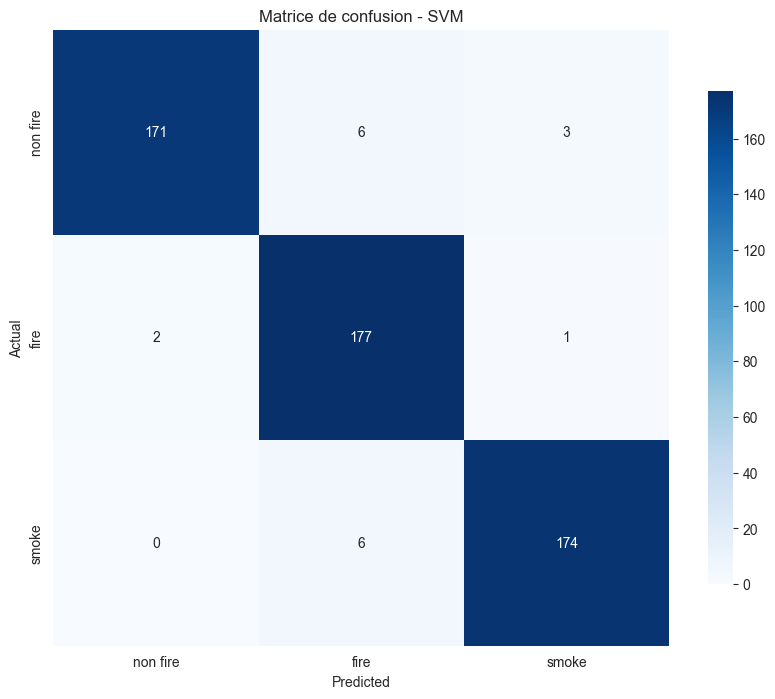

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_svm)
labels = ['non fire', 'fire', 'smoke']

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion - SVM')
plt.show()


### Interpretation

The confusion matrix presented above illustrates the measurements from the classification report. We can observe that the model predicts the all classes well. Whenever an image belongs to the class "fire" and is not correctly classified, it is confused for "non fire". However, these instances is rare as "fire" is most often well-classified. When the actual image corresponds to "smoke", the model classifies it as "fire" in all cases of the test set. In the case of "non  fire", it seems to be the model with the most instances of misclassification, as it is confused with "fire" and "smoke" in a few, but notable cases compared to the other classes. Indeed, "non fire" is misclassified as "fire" 6 times and as "smoke" 3 times. This suggests that the model has more difficulty distinguishing "non fire" from the other two classes, possibly due to visual similarities in certain images.

### K-Nearest Neighbors (KNN)


In [26]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 21)}

grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=5))
grid_search.fit(X_train_scaled, y_train_resampled)

optimal_k = grid_search.best_params_['n_neighbors']
print("Optimal K found:", optimal_k)


/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Optimal K found: 2


In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


model_knn = KNeighborsClassifier(n_neighbors=optimal_k)

start = time.time()
model_knn.fit(X_train_scaled, y_train_resampled)
end = time.time()

knn_time = end - start
y_pred_knn = model_knn.predict(X_test_scaled)

print("Training time for KNN:", knn_time, "seconds")
optimal_k = grid_search.best_params_['n_neighbors']
print("Optimal K found:", optimal_k)


Training time for KNN: 0.006554841995239258 seconds
Optimal K found: 2


### Interpretation
After training the KNN model, we found that the optimal number of neighbors is 2. The training time for the model was approximately 0.0066 seconds, which is significantly shorter than that of the SVM model.

In [30]:
target_names = ['non fire', 'fire', 'smoke']
print("Classification report for KNN:")
print(classification_report(y_test,y_pred_knn, target_names=target_names))

Classification report for KNN:
              precision    recall  f1-score   support

    non fire       0.94      0.97      0.95       180
        fire       0.94      0.93      0.94       180
       smoke       0.98      0.96      0.97       180

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540



### Interpretation
The classification report indicates that the KNN model performs well across all classes. The precision, recall, and F1-score for each class are all above 0.90. The model is particularly effective in identifying the "smoke" class with an F1-Score of 0.97. The "non fire" class has a slightly lower F1-score of 0.95, but it remains very high. Finally, the "fire" class has the lowest F1-score of 0.94, but it is still good. Overall, the model reaches an accuracy score of 0.95, which means that it correctly classifies 95% of the test samples. Overall, the KNN model demonstrates strong performance in classifying the different classes in the dataset. It also shows a faster training time compared to the SVM model.

### Matrice de confusion pour KNN

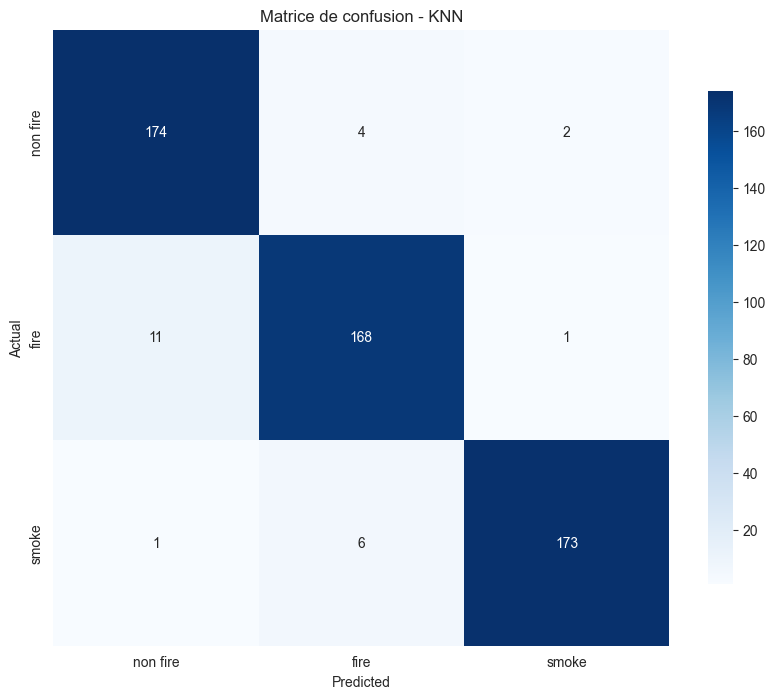

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrice_confusion = confusion_matrix(y_test, y_pred_knn)
labels = ['non fire', 'fire', 'smoke']

plt.figure(figsize=(10, 8))
sns.heatmap(
    matrice_confusion,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matrice de confusion - KNN')
plt.show()


### Interpretation
The confusion matrix for the KNN model shows in a more visual way that the model performs well across all classes. In the cases where an image belonging to the "fire" class is misclassified, it is mostly confused with the "non fire" class. This situation is likely due to visual similarities between certain images in these two classes. This confusion does not occure often, with a total of 11 misclassification of "fire" as "non fire". On the other hand, the "non fire" class is very well classified, with only 6 misclassifications, of which 2 are confused with "smoke", and 4 with "fire". The "smoke" class is mainly misidentified as "fire", with a total of 6 misclassifications. Overall, the KNN model demonstrates a strong performance in classifying the different classes in the dataset, with only a few instances of misclassification. However, the results are slightly less good than those of the SVM model.

## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

model_decision_tree = DecisionTreeClassifier()

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

start = time.time()
model_decision_tree.fit(X_train_resampled, y_train_resampled)
end = time.time()

decision_tree_time = end - start

y_pred_decision_tree = model_decision_tree.predict(X_test)
print("Training time for Decision Tree:", decision_tree_time, "seconds")

/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Training time for Decision Tree: 2.0526599884033203 seconds


In [23]:
print("Classification report for Decision Tree:")
print(classification_report(y_test,y_pred_decision_tree, target_names=target_names))

Classification report for Decision Tree:
              precision    recall  f1-score   support

    non fire       0.89      0.89      0.89       180
        fire       0.91      0.94      0.92       180
       smoke       0.94      0.91      0.92       180

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.91      0.91      0.91       540



### Interpretation
The classification report indicates that the Decision Tree model performs pretty well across all classes. The "fire" and "smoke" classes have the highest F1-scores of 0.92. The "non fire" class has a slightly lower F1-score of 0.89, but it remains good. Overall, the model reaches an accuracy score of 0.91, which signifies that it correctly categorizes 92% of the test samples. The training time for the Decision Tree model was approximately 2.053 seconds, which is fast compared to the SVM models, but slower than the KNN model. Overall, the Decision Tree model demonstrates a solid performance, but it is slightly less effective than the SVM and KNN models.

### Confusion Matrix for Decision Tree


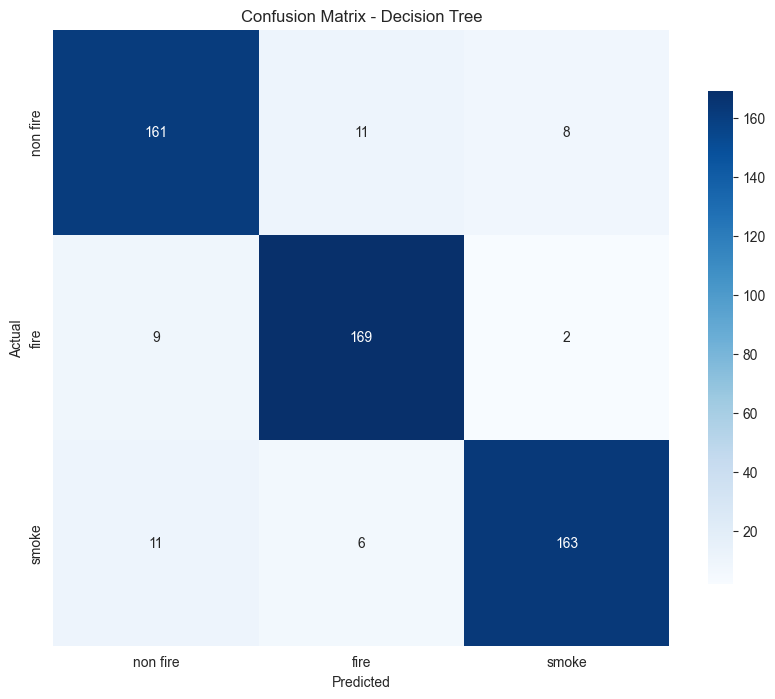

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred_decision_tree)

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Decision Tree")
plt.show()


### Interpretation
The confusion matrix shows that the "non fire" class is the least well-classified class, with 19 overall misclassifications. Indeed, it is confused with "fire" 11 times and with "smoke" 8 times. The "smoke" class is slightly better classified, with only 17 misclassifications, of which 11 are confused with "fire" and 6 with "non fire". Finally, the "fire" class is the best classified, with 11 misclassifications, which most are confused with "non fire". Overall, the Decision Tree model demonstrates a good performance in classifying the different classes in the dataset. However, this model is less effective than the SVM and KNN models.

# Naive Bayes

In [32]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

naive_bayes = GaussianNB()
start = time.time()
naive_bayes.fit(X_train_scaled, y_train_resampled)
end = time.time()

naive_bayes_time = end - start

y_pred_nb = naive_bayes.predict(X_test_scaled)
print("Training time for Naive Bayes:", naive_bayes_time, "seconds")


Training time for Naive Bayes: 0.027879953384399414 seconds


/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/eglantineclervil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [33]:
print("Classification report for Naive Bayes:")
print(classification_report(y_test,y_pred_nb, target_names=target_names))

Classification report for Naive Bayes:
              precision    recall  f1-score   support

    non fire       0.91      0.94      0.93       180
        fire       0.92      0.96      0.94       180
       smoke       0.98      0.90      0.94       180

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540



### Interpretation
The classification report indicates that the Naive Bayes model performs well across all classes. The precision, recall, and F1-score for each class are all above 0.90. The model is effective in identifying both the "non fire" and "fire" classes, with F1-scores of 0.94 for each. The "smoke" class has a slightly lower F1-score of 0.93, but it remains very good. The Naive Bayes model achieves 93% accuracy, which demonstrates a strong overall performance. The training time for the Naive Bayes model was approximately 0.028 seconds, which is very fast. Overall, the Naive Bayes model shows a great performance in classifying the different classes in the dataset, with a very quick training time.

### Confusion matrix for Naive Bayes

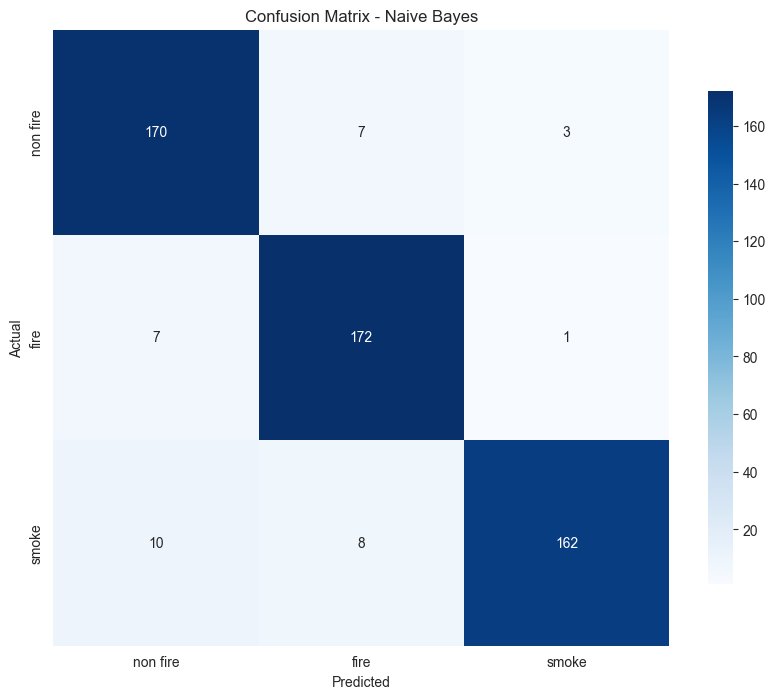

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, y_pred_nb)
labels = ['non fire', 'fire', 'smoke']

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={"shrink": .8}
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


### Interpretation
The confusion matrix for the Naive Bayes model shows that the "non fire" class is most often misclasified for "fire", with a total of 7 misclassifications. It is also confused with "smoke" 3 times. The "smoke" class is mainly misidentified as "fire", with a total of 18 misclassifications. Indeed, it is most frequently incorrectly identified for "non fire". Finally, the "fire" class produces the least misclassifications, with a total of 8, which are mostly confused with "non fire".

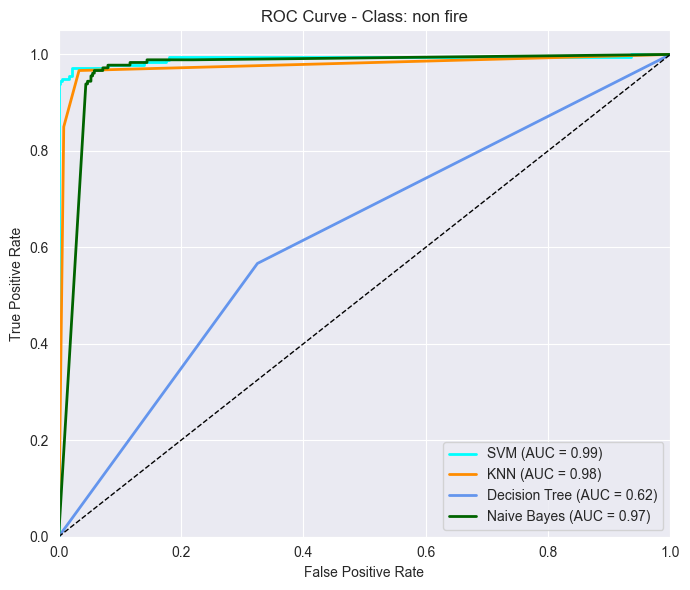

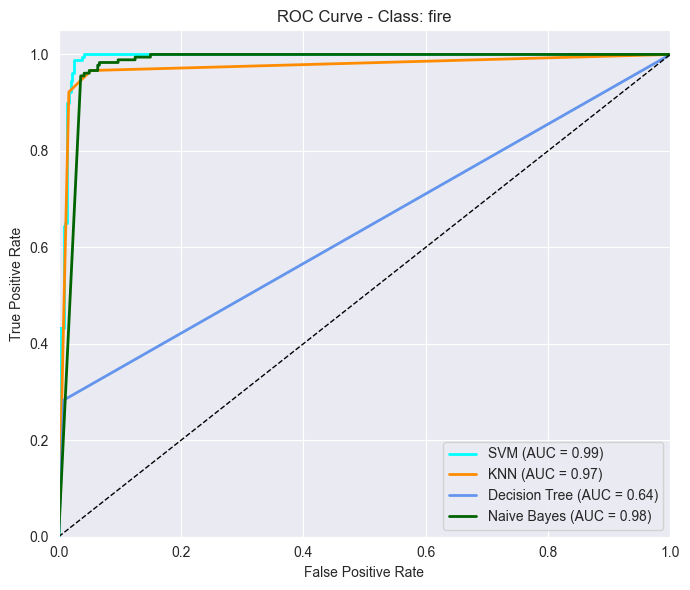

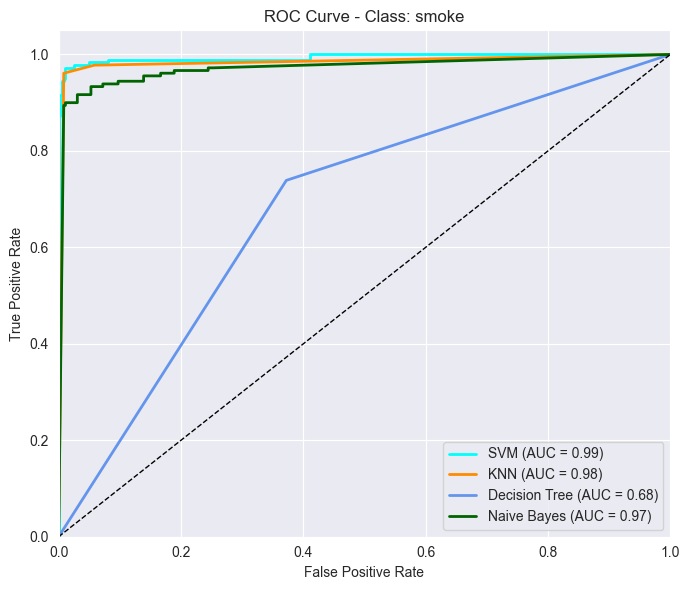

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(range(3)))
n_classes = y_test_bin.shape[1]

models = [
    model_svm.best_estimator_,
    model_knn,
    model_decision_tree,
    naive_bayes
]

model_names = ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes']
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']

labels = {
    0 : 'non fire',
    1 : 'fire',
    2 : 'smoke'
}


for class_idx in range(n_classes):
    plt.figure(figsize=(7, 6))

    for model, name, color in zip(models, model_names, colors):
        y_score = model.predict_proba(X_test_scaled)

        fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_score[:, class_idx])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Class: {labels[class_idx]}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


### Interpretation

The ROC curves for each class show that the SVM model consistently outperforms the other models across all classes (AUC score = 0.99 for all classes). This high score indicates that the SVM is the most effective model for distinguishing between the different classes. Despite the higher training time of the SVM model, we can see that it compensates with superior performance. The KNN model also performs well, with AUC scores of 0.98, 0.97, and 0.98 for the "non fire", "fire" and "smoke" classes respectively. The Naive Bayes model shows the same performance as KNN for the each class, with AUC scores of 0.97, 0.98, and 0.97 for the "non fire", "fire" and "smoke" classes respectively. The Decision Tree model has the lowest performance. Indeed, the score seems quite low for all classes, which indicates that this model is less effective in distinguishing between the different classes.

# Graphical comparison of models

           Model  Accuracy  F1 Score       AUC    Recall
0            SVM  0.966667  0.966752  0.992186  0.966752
1            KNN  0.953704  0.953759  0.977904  0.953704
2  Decision Tree  0.912963  0.912992  0.934722  0.912963
3    Naive Bayes  0.933333  0.933392  0.973092  0.933333


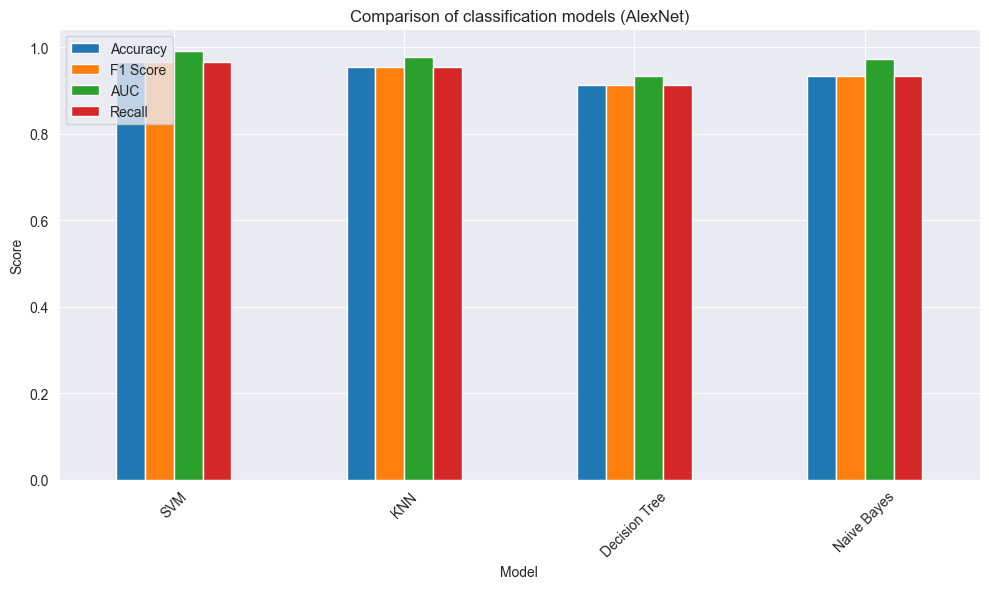

In [40]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

results = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, model_svm.predict(X_test_scaled)),
        accuracy_score(y_test, model_knn.predict(X_test_scaled)),
        accuracy_score(y_test, model_decision_tree.predict(X_test)),
        accuracy_score(y_test, naive_bayes.predict(X_test_scaled))
    ],
    'F1 Score': [
        f1_score(y_test, model_svm.predict(X_test_scaled), average='weighted'),
        f1_score(y_test, model_knn.predict(X_test_scaled), average='weighted'),
        f1_score(y_test, model_decision_tree.predict(X_test), average='weighted'),
        f1_score(y_test, naive_bayes.predict(X_test_scaled), average='weighted')
    ],
    'AUC': [
        roc_auc_score(y_test, model_svm.predict_proba(X_test_scaled), multi_class='ovr'),
        roc_auc_score(y_test, model_knn.predict_proba(X_test_scaled), multi_class='ovr'),
        roc_auc_score(y_test, model_decision_tree.predict_proba(X_test), multi_class='ovr'),
        roc_auc_score(y_test, naive_bayes.predict_proba(X_test_scaled), multi_class='ovr')
    ],
    'Recall': [
        model_svm.score(X_test_scaled, y_test),
        model_knn.score(X_test_scaled, y_test),
        model_decision_tree.score(X_test, y_test),
        naive_bayes.score(X_test_scaled, y_test)
    ],
})


print(results)
plt.figure(figsize=(10, 6))
results.plot(kind='bar', x='Model', y=['Accuracy', 'F1 Score', 'AUC', 'Recall'], rot=0, ax=plt.gca())
plt.title('Comparison of classification models (AlexNet)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



### Interpretation
SVM seems to be the most reliable and balanced model here, with KNN as a decent alternative. Decision Tree is the least effective model, with lower scores across all metrics. Naive Bayes performs reasonably well, but is outperformed by SVM and KNN in most metrics.


           Model  Training Time
0            SVM     634.495077
1            KNN       0.006555
2  Decision Tree       2.052660
3    Naive Bayes       0.027880


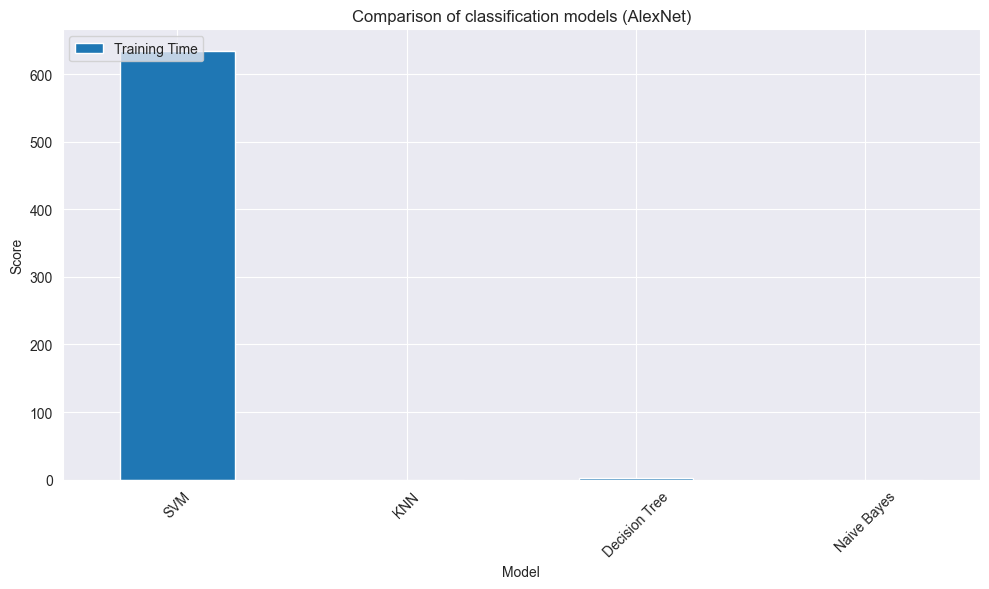

In [47]:
import matplotlib.pyplot as plt
training_times = {
    'Model': ['SVM', 'KNN', 'Decision Tree', 'Naive Bayes'],
    'Training Time': [svm_time, knn_time, decision_tree_time, naive_bayes_time]
}
results = pd.DataFrame(training_times)
print(results)

plt.figure(figsize=(10, 6))
results.plot(kind='bar', x='Model', y='Training Time', ax=plt.gca())
plt.title('Comparison of classification models (AlexNet)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


         Model  Training Time
0          KNN       0.006555
1  Naive Bayes       0.027880


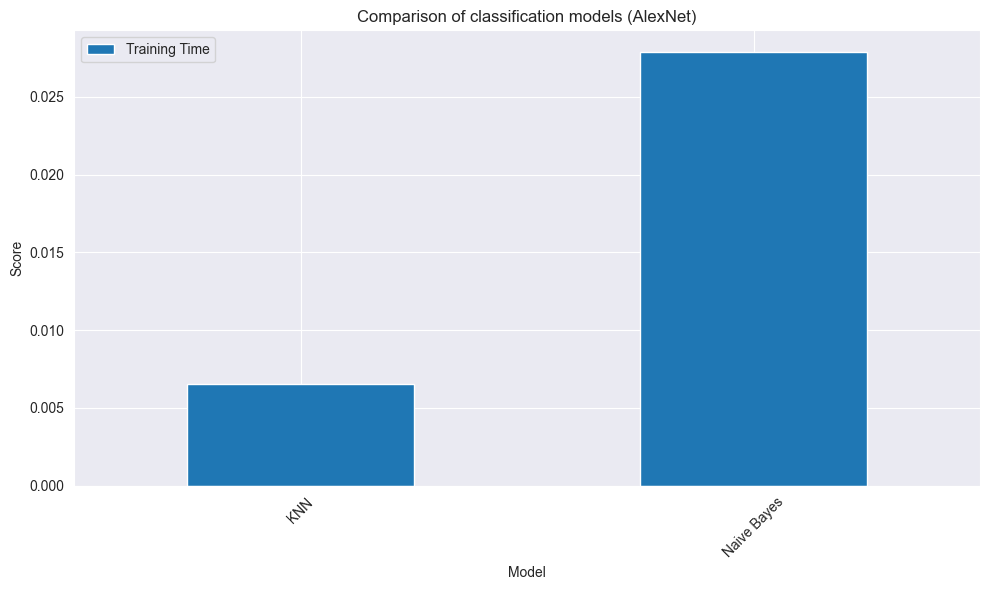

In [48]:
import matplotlib.pyplot as plt
training_times_2 = {
    'Model': ['KNN', 'Naive Bayes'],
    'Training Time': [knn_time, naive_bayes_time]
}
results = pd.DataFrame(training_times_2)
print(results)

plt.figure(figsize=(10, 6))
results.plot(kind='bar', x='Model', y='Training Time', ax=plt.gca())
plt.title('Comparison of classification models (AlexNet)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### Interpretation
The training time comparison shows that the KNN and Naive Bayes models are significantly faster to train compared to the SVM and Decision Tree models. KNN has a training time of approximately 0.0066 seconds, while Naive Bayes is even faster at around 0.028 seconds. In contrast, the SVM model takes about 634.495 seconds to train, and the Decision Tree model takes around 2.053 seconds. This indicates that KNN and Naive Bayes are more efficient in terms of training time.

In summary, while SVM offers the best performance, it comes with a high training time cost. KNN and Naive Bayes provide a good balance between performance and training time, with KNN being slightly more accurate and faster than Naive Bayes.